In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Define the directories
train_dir = 'Plant_Detection_Dataset/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'Plant_Detection_Dataset/New Plant Diseases Dataset(Augmented)/val'
test_dir = 'Plant_Detection_Dataset/test'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(128, 128),
                                                batch_size=32,
                                                class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128, 128),
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 70605 images belonging to 41 classes.
Found 17619 images belonging to 41 classes.
Found 33 images belonging to 8 classes.


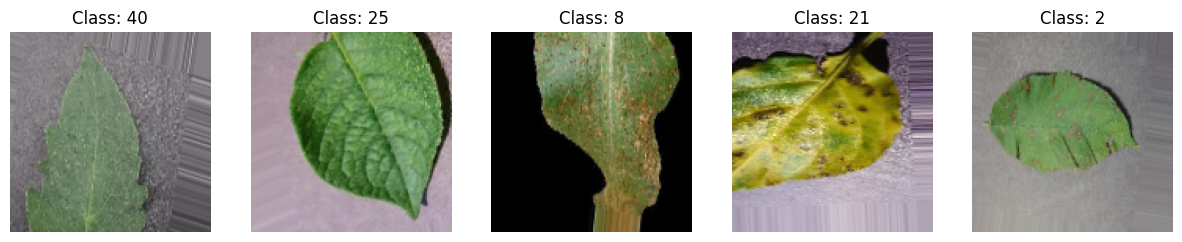

In [5]:
images, labels = next(train_generator)
num_images = 5
plt.figure(figsize=(15, 15))
# Loop through the images and display them
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.title("Class: {}".format(np.argmax(labels[i]))) 
    plt.axis('off')  
plt.show()

In [6]:
# Build the custom CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening and Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.save('pdd.keras')

c:\Users\Oswin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [5]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_custom_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/20


c:\Users\Oswin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 729s 331ms/step - accuracy: 0.2325 - loss: 2.7789 - val_accuracy: 0.5879 - val_loss: 1.3593
Epoch 2/20
1972/2197 ━━━━━━━━━━━━━━━━━━━━ 20:11 5s/step - accuracy: 0.5863 - loss: 1.3631

In [8]:
# Load the best model
model.load_weights('best_custom_cnn_model.keras')

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Optional: Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get the true labels and predictions
val_generator.reset()
predictions = model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Classification report
class_report = classification_report(true_labels, predicted_labels, target_names=list(val_generator.class_indices.keys()))
print(class_report)


c:\Users\Oswin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


551/551 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.8771 - loss: 0.4631
Validation Accuracy: 87.79%
551/551 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step
[[13 15 13 ...  8 13 35]
 [10 19 17 ... 17  9 22]
 [ 8 16 10 ...  7  4 28]
 ...
 [11 18  7 ... 11 20 21]
 [ 7 10 15 ...  8 11 28]
 [ 9 10  9 ... 12 13 22]]
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.03      0.03      0.03       504
                                 Apple___Black_rot       0.04      0.04      0.04       497
                          Apple___Cedar_apple_rust       0.02      0.02      0.02       440
                                   Apple___healthy       0.02      0.02      0.02       502
                               Blueberry___healthy       0.03      0.02      0.02       454
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       421
                 Cherry_(including_sour)___healthy

In [7]:
acc,loss= model.evaluate(test_generator)
prin("Test Loss:",loss)
print("Test Accuracy:",acc)

Test Loss: 0.1884478338
Test Accuracy: 91.45%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
The model predicts: Money_Plant__Healty


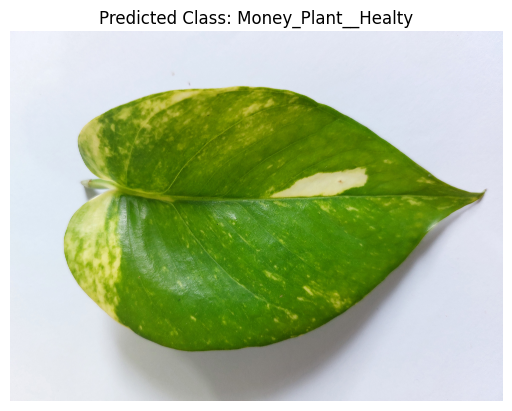

In [9]:
# Load and preprocess the test image
img_path = 'test.jpg'  # Replace with the path of the image you want to test
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Rescale the image

# Predict the class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Get the class label
class_label = list(train_generator.class_indices.keys())[predicted_class]
print(f"The model predicts: {class_label}")

# Display the image with its prediction
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted Class: {class_label}")
plt.axis('off')
plt.show()


In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Initialize the camera
camera = cv2.VideoCapture(0)  # '0' is the default camera

# Ensure the camera is opened successfully
if not camera.isOpened():
    print("Error: Could not open the camera.")
else:
    while True:
        # Capture a frame from the camera
        ret, frame = camera.read()

        if ret:
            # Resize the image to the target size (128, 128) using OpenCV
            frame_resized = cv2.resize(frame, (128, 128))

            # Convert the resized frame to a NumPy array and preprocess it for the model
            img_array = np.array(frame_resized)  # Convert the frame to an array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input
            img_array = img_array.astype('float32') / 255.  # Normalize the image data to [0, 1]

            # Predict the class
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction)

            # Get the class label (assuming you have a trained model with class indices)
            class_label = list(train_generator.class_indices.keys())[predicted_class]

            # Display the original frame with the predicted class
            cv2.putText(frame, f"Predicted Class: {class_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Camera - Press q to quit', frame)

            # Press 'q' to quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Error: Failed to capture the frame.")
            break

    # Release the camera and close any open windows
    camera.release()
    cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━